In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Our subject for this project will be finding a possible correlation between the number of Ubers picking up passengers and traffic volume for given hourly time ranges. The question we want to ask is does the time of uber pickup have any correlation with traffic volume at the time? Just to clarify, the time of uber pickup would be the number of uber called for a certain hourly time range. 

Originally, we wanted to work with multiple months, but ultimately we decided to only work with the month of September from the 13th and onwards. We chose this because we found that this has the most variation and was most interesting to work with. We also added more layers of data analysis to find our more about the relationship between number of uber pickups and traffic volume for the given time ranges.

Uber Data Source: https://data.world/data-society/uber-pickups-in-nyc

In [2]:
traffic_volume_raw = pd.read_csv("Traffic_Volume_Counts__2014-2018_.csv")
traffic_volume_raw.head()
print(traffic_volume_raw.columns)

Index(['ID', 'Segment ID', 'Roadway Name', 'From', 'To', 'Direction', 'Date',
       '12:00-1:00 AM', '1:00-2:00AM', '2:00-3:00AM', '3:00-4:00AM',
       '4:00-5:00AM', '5:00-6:00AM', '6:00-7:00AM', '7:00-8:00AM',
       '8:00-9:00AM', '9:00-10:00AM', '10:00-11:00AM', '11:00-12:00PM',
       '12:00-1:00PM', '1:00-2:00PM', '2:00-3:00PM', '3:00-4:00PM',
       '4:00-5:00PM', '5:00-6:00PM', '6:00-7:00PM', '7:00-8:00PM',
       '8:00-9:00PM', '9:00-10:00PM', '10:00-11:00PM', '11:00-12:00AM'],
      dtype='object')


The traffic volume data had excess columns we did not need/did not want to include in our final clean dataset. We also chose to restrict the time ranges from 7:00AM to 6:00PM since this is usually when a sizeable amount of cars are on the road.

In [3]:
#we have decided to look only at times from 7 AM - 6 PM for traffic volume

traffic_volume = traffic_volume_raw.drop(['12:00-1:00 AM','1:00-2:00AM',
                                          '2:00-3:00AM','3:00-4:00AM',
                                         '4:00-5:00AM','5:00-6:00AM',
                                          '6:00-7:00AM', '6:00-7:00PM',
                                          '7:00-8:00PM','8:00-9:00PM',
                                          '9:00-10:00PM','10:00-11:00PM',
                                          '11:00-12:00AM'], axis=1)

#traffic_volume is without the extra time as we are looking traffic volume during the workday. 

traffic_volume.head()

,ID,Segment ID,Roadway Name,From,To,Direction,Date,7:00-8:00AM,8:00-9:00AM,9:00-10:00AM,10:00-11:00AM,11:00-12:00PM,12:00-1:00PM,1:00-2:00PM,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM
0,2,70376,3 Avenue,East 154 Street,East 155 Street,NB,9/13/2014,180.0,223.0,272.0,386.0,339.0,513,506,520,611,573,546
1,2,70376,3 Avenue,East 155 Street,East 154 Street,SB,9/13/2014,219.0,226.0,273.0,317.0,325.0,403,414,379,376,329,362
2,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,EB,9/13/2014,113.0,169.0,210.0,182.0,245.0,244,233,280,272,264,236
3,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,WB,9/13/2014,142.0,198.0,212.0,205.0,237.0,257,245,237,276,223,240
4,62,147673,Broadway,West 242 Street,240 Street,SB,9/13/2014,354.0,473.0,567.0,634.0,781.0,785,779,732,809,707,675


In [4]:
#removed unecessary data to cleanup final dataframe
time_list = ['7:00-8:00AM','8:00-9:00AM','9:00-10:00AM', '10:00-11:00AM', '11:00-12:00PM',
             '12:00-1:00PM', '1:00-2:00PM', '2:00-3:00PM', '3:00-4:00PM', '4:00-5:00PM', '5:00-6:00PM']


day_list =  ['13','14','15','16','17','18','19','20',
           '21','22','23','24','25','26','27','28','29','30']

newday_list = []
day_list = list(map(lambda x : "9/{}/2014".format(x), day_list))
for day in day_list:
    rows = traffic_volume.loc[traffic_volume['Date'] == day]
    means_of_current_day = []
    for time in time_list:
        total = 0
        for i in range(len(rows)):
            j = rows.columns.get_loc(time)
            total += rows.iat[i,j]
        means_of_current_day.append(total/float(len(rows)))
    newday_list.append(means_of_current_day)

#making a new dataframe   
traffic_mean = pd.DataFrame(newday_list, columns = time_list, index = day_list)
traffic_mean.head()

,7:00-8:00AM,8:00-9:00AM,9:00-10:00AM,10:00-11:00AM,11:00-12:00PM,12:00-1:00PM,1:00-2:00PM,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM
9/13/2014,414.788732,531.323944,611.112676,666.450704,760.126761,794.619718,799.661972,821.873239,814.154930,846.323944,857.647887
9/14/2014,283.394366,363.802817,481.042254,620.633803,710.126761,753.577465,783.169014,799.985915,828.366197,840.028169,823.042254
9/15/2014,988.211268,988.690141,765.845070,653.788732,637.366197,665.816901,704.464789,789.619718,912.549296,977.619718,992.154930
9/16/2014,958.000000,895.887324,774.943662,663.028169,636.140845,637.084507,679.422535,773.802817,890.901408,974.140845,982.464789
9/17/2014,971.535211,937.338028,751.746479,644.619718,651.253521,666.098592,705.577465,833.309859,934.605634,967.845070,987.676056


explain what we did to get our final datasets

In [5]:
#inserting uber data
uber = pd.read_csv('uber-data.csv')

#number of days in september being analyzed
date_list = ['13','14','15','16','17','18','19','20',
            '21','22','23','24','25','26','27','28','29','30']

#number of hours
hours_list = ['7','8','9','10','11','12','13','14','15','16','17']
    
uber_data = uber["Date Called"].tolist()  

#counting each day and hour
total_list = []
uber_date = []
date_str = []
for date in date_list:
    find_date = ('9/'+date+'/2014')
    date_str.append(find_date)
    uber_date = [s for s in uber_data if find_date in s]
    for hour in hours_list:
        hour_str = " " + hour + ":"
        uber_hours = [s for s in uber_date if hour_str in s]
        count = len(uber_hours)
        total_list.append(count)

total_list = np.reshape(total_list, (len(date_list), len(hours_list)))
        
uber_counts = pd.DataFrame(total_list, columns = time_list, index = date_str)
uber_counts.head()
            

,7:00-8:00AM,8:00-9:00AM,9:00-10:00AM,10:00-11:00AM,11:00-12:00PM,12:00-1:00PM,1:00-2:00PM,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM
9/13/2014,249,353,437,479,526,572,661,983,1098,1092,1105
9/14/2014,211,293,365,413,543,506,540,559,638,662,679
9/15/2014,575,591,440,367,376,384,451,534,643,802,882
9/16/2014,849,918,762,686,498,474,536,643,801,858,964
9/17/2014,719,608,471,456,446,492,571,656,747,915,1037


explain what we did to get our final datasets 

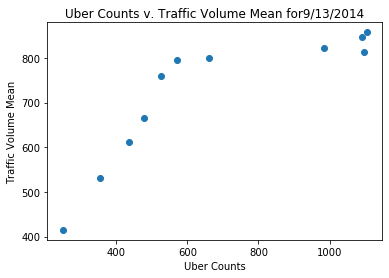

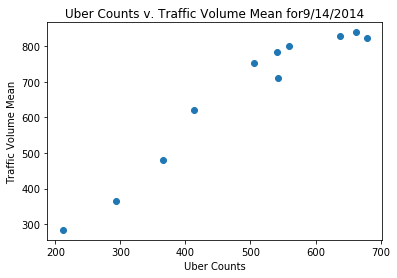

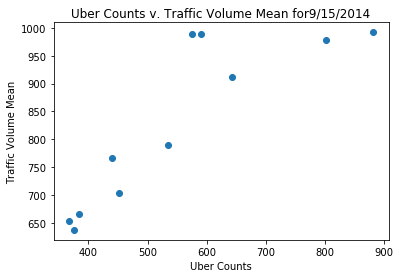

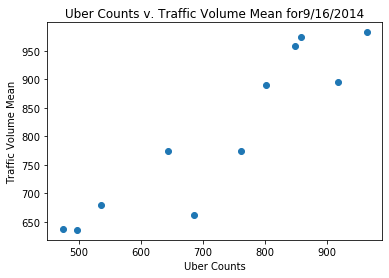

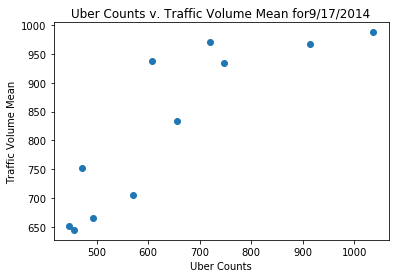

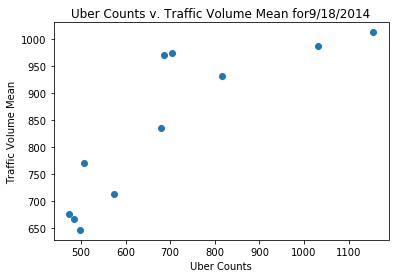

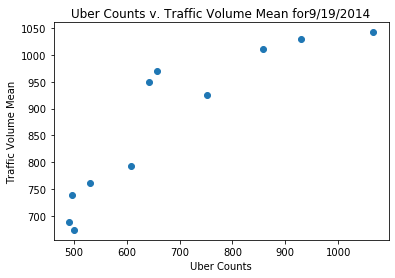

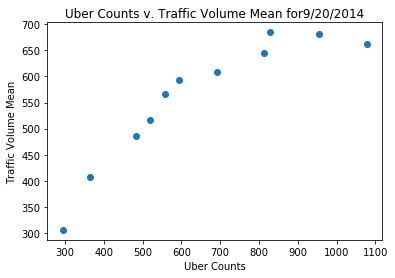

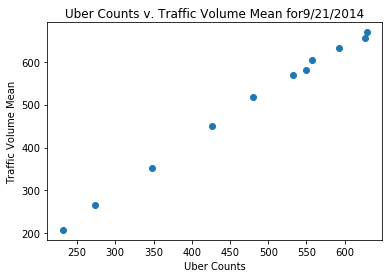

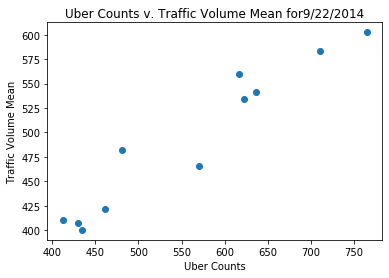

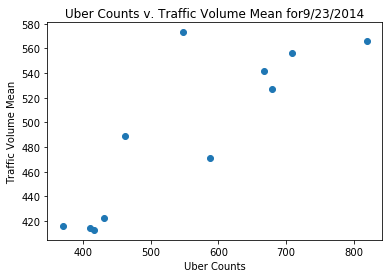

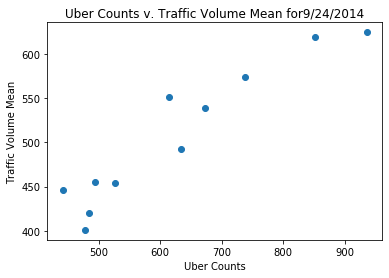

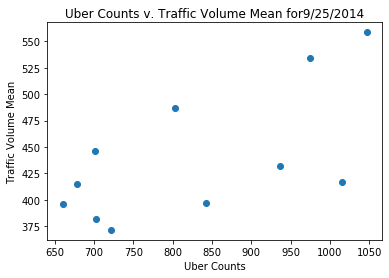

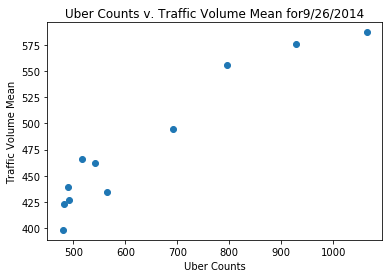

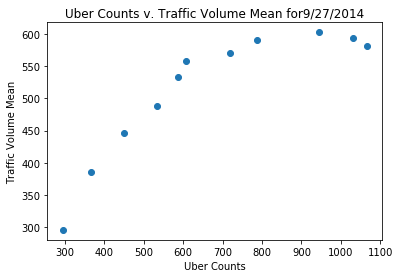

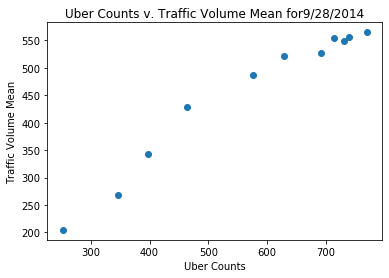

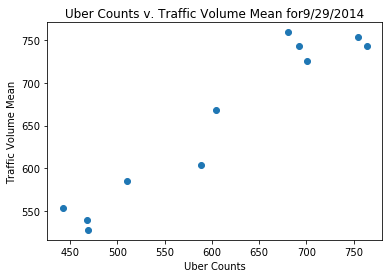

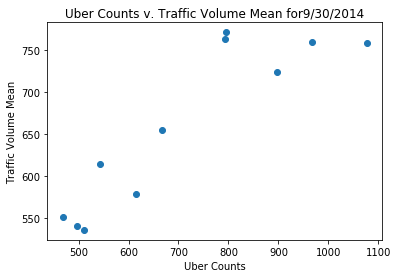

In [6]:
#Separate scatterplots for each date

for date in date_list:
    find_date = ('9/'+date+'/2014')
    plt.scatter(uber_counts.loc[find_date], traffic_mean.loc[find_date])
    plt.xlabel('Uber Counts')
    plt.ylabel('Traffic Volume Mean')
    plt.title('Uber Counts v. Traffic Volume Mean for'+find_date)
    plt.show()

#say something here

talk about next steps to take, why we chose to create these new dataframes

In [7]:
#make new dataframes for uber and traffic volume data for future Linear Regression 

newuber_df = pd.DataFrame(uber_counts.mean().to_dict(),index=[uber_counts.index.values[-1]])
newuber_df = newuber_df.rename(index = {'9/30/2014':'Uber Counts Mean'})
newuber_df.head()

,7:00-8:00AM,8:00-9:00AM,9:00-10:00AM,10:00-11:00AM,11:00-12:00PM,12:00-1:00PM,1:00-2:00PM,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM
Uber Counts Mean,559.111111,563.611111,505.111111,488.777778,504.0,503.333333,575.444444,673.888889,775.166667,865.222222,936.833333


In [8]:
newtraffic_df = pd.DataFrame(traffic_mean.mean().to_dict(), index = [traffic_mean.index.values[-1]])
newtraffic_df = newtraffic_df.rename(index = {'9/30/2014':'Traffic Volume Mean'})
newtraffic_df.head()

,7:00-8:00AM,8:00-9:00AM,9:00-10:00AM,10:00-11:00AM,11:00-12:00PM,12:00-1:00PM,1:00-2:00PM,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM
Traffic Volume Mean,586.349986,614.890602,556.154634,530.305455,551.968468,576.788778,600.1091,659.313755,718.491115,750.837422,754.831442


In [9]:
#Transposing Dataframes for Linear Regression
newuber_df = newuber_df.T
newuber_df.head()

,Uber Counts Mean
7:00-8:00AM,559.111111
8:00-9:00AM,563.611111
9:00-10:00AM,505.111111
10:00-11:00AM,488.777778
11:00-12:00PM,504.000000


In [10]:
newtraffic_df = newtraffic_df.T
newtraffic_df.head()

,Traffic Volume Mean
7:00-8:00AM,586.349986
8:00-9:00AM,614.890602
9:00-10:00AM,556.154634
10:00-11:00AM,530.305455
11:00-12:00PM,551.968468


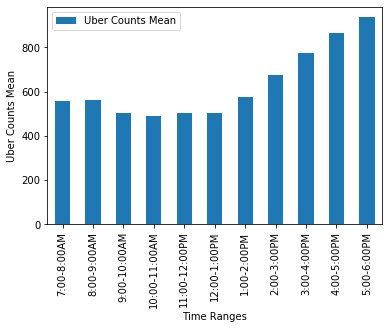

In [11]:
#Data Visualization for Uber Counts
newuber_df.plot.bar()
plt.xlabel('Time Ranges')
plt.ylabel('Uber Counts Mean')
plt.show()

Why we chose this data visualization and what it shows us and how it contributes to the question we want to answer and what not

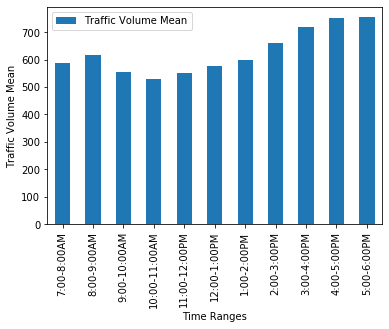

In [12]:
#Data Visualization for Traffic Volume
newtraffic_df.plot.bar()
plt.xlabel('Time Ranges')
plt.ylabel('Traffic Volume Mean')
plt.show()

What this shows about this data and how it contributes to answering our initial q

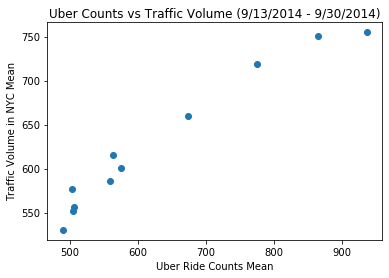

In [13]:
#Scatterplots

plt.scatter(newuber_df, newtraffic_df)
plt.xlabel('Uber Ride Counts Mean')
plt.ylabel('Traffic Volume in NYC Mean')
plt.title('Uber Counts vs Traffic Volume (9/13/2014 - 9/30/2014)')
plt.show()

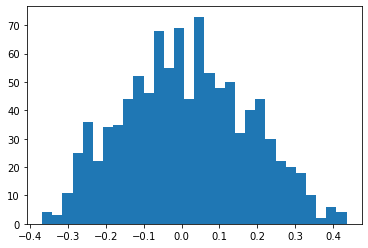

In [29]:
#writing a permuated y
def permuted_y():
    return np.random.permutation(newtraffic_df.copy())

perm_y_slopes = np.zeros(1000)
slopes = np.zeros(1000)

for i in range(1000):
    perm_y_slopes[i] = LinearRegression().fit(newuber_df, permuted_y()).coef_
    
plt.hist(perm_y_slopes, bins = 30)
plt.show()

#explain findings and shit and why we did this 

why we transposed and what we plan on doing

In [15]:
#Linear Regression
model1 = LinearRegression().fit( newuber_df[['Uber Counts Mean']], newtraffic_df[['Traffic Volume Mean']] )
print ('The regression slope of model 1 is:',model1.coef_[0])
print ('The regression intercept of model 1 is:',model1.intercept_[0])
print ('The r-squared of model 1 is:',model1.score(newuber_df[['Uber Counts Mean']], newtraffic_df[['Traffic Volume Mean']] ))

The regression slope of model 1 is: [0.50143538]
The regression intercept of model 1 is: 310.43764774553574
The r-squared of model 1 is: 0.9592810330761794


#### Evaluation of significance: Random Y Permutation
When we randomized our y-axis it is around zero. The regression slope calculated is closer to 0.5 which is not on the histogram. Therefore, there is a strong implication that the data have strong, linear correlation between the Traffic Volume in NYC and Uber Counts in NYC.

explain findings and if it agrees with hypothesis and shits 

### Data Analysis: Analyzing traffic volume and uber counts based on weekday and weekends

In this instance, we decided to also analyze the trend for uber counts and traffic volume based on weekends and weekdays. We thought that it would intersting to analyze because people's driving habits should change as most people no longer need to drive to work during a typical 9-5. We noticed, when doing the previous data analysis, that there were some instances when the traffic volume or uber counts was higher than we thought during the weekend. Therefore, we wanted to compare them more directly and analyze the standard deviation.

#### Research question: We would like to examine if there is any signfigance difference in the traffic volume and uber pickup counts on a weekday verus the weekend.

**Hypothesis**: We predict that there is a difference in traffic volume and uber pickup counts on a weekday verus the weekend. We expect that there are less traffic volume and uber pickup counts on a weekend compared to a weekday because we assume more people stay home on a weekday between the hours 9 AM to 5 PM.

In [16]:
#separating traffic data into weekdays and weekends
days  = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_mean = np.zeros((7,11))
for i in range(len(days)):
    day = 13 + i
    dates = day + 7*(np.arange(np.floor((30-day)/7)+1))
    day_list = [str(int(a)) for a in dates]
    day_list = list(map(lambda x : "9/{}/2014".format(x), day_list))
    day_traf = np.zeros(11)
    for d in day_list:
        day_traf += traffic_mean.loc[d]
    
    day_of_week_mean[i, :] = day_traf/len(day_list)
    
# print(day_of_week_mean)
# #     uber days of the week dataframe
traffic_day_of_week = pd.DataFrame(day_of_week_mean, columns = time_list, index = days)
print ("Traffic Volume Means for Days of the Week")
traffic_day_of_week.head()

Traffic Volume Means for Days of the Week


,7:00-8:00AM,8:00-9:00AM,9:00-10:00AM,10:00-11:00AM,11:00-12:00PM,12:00-1:00PM,1:00-2:00PM,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM
Monday,338.885435,441.234520,514.164560,556.890051,619.854124,648.026257,659.033453,685.525729,700.393582,707.191435,700.262370
Tuesday,231.979504,298.937462,392.402233,499.815759,571.181532,614.820089,630.235437,653.224793,672.026826,691.146545,676.166988
Wednesday,755.132745,769.442389,617.319920,534.335662,521.806328,542.224339,570.502122,641.446381,726.588374,771.610148,779.507000
Thursday,756.832441,743.734261,626.015324,538.773625,528.894363,534.586922,560.073950,633.072134,714.043707,763.237066,768.660005
Friday,755.302489,744.372502,603.198821,522.780789,535.493040,555.950459,579.631756,663.021209,754.297003,793.666721,806.024075


In [17]:
#separating data into weekdays and weekends
days  = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
uber_day_of_week_mean = np.zeros((7,11))
for i in range(len(days)):
    day = 13 + i
    dates = day + 7*(np.arange(np.floor((30-day)/7)+1))
    day_list = [str(int(a)) for a in dates]
    day_list = list(map(lambda x : "9/{}/2014".format(x), day_list))
    u_day = np.zeros(11)
    for d in day_list:
        u_day += uber_counts.loc[d]
    
    uber_day_of_week_mean[i, :] = np.round(u_day/len(day_list))



#     uber days of the week dataframe
uber_day_of_week = pd.DataFrame(uber_day_of_week_mean, columns = time_list, index = days)
print ("Uber Count Means for Days of the Week")
uber_day_of_week.head()

Uber Count Means for Days of the Week


,7:00-8:00AM,8:00-9:00AM,9:00-10:00AM,10:00-11:00AM,11:00-12:00PM,12:00-1:00PM,1:00-2:00PM,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM
Monday,279.0,361.0,456.0,511.0,557.0,591.0,690.0,861.0,957.0,1026.0,1083.0
Tuesday,231.0,304.0,370.0,434.0,533.0,556.0,594.0,610.0,656.0,687.0,679.0
Wednesday,630.0,629.0,503.0,416.0,427.0,419.0,474.0,569.0,660.0,756.0,804.0
Thursday,770.0,753.0,589.0,533.0,473.0,437.0,527.0,632.0,793.0,845.0,953.0
Friday,696.0,611.0,482.0,466.0,465.0,466.0,549.0,644.0,742.0,884.0,986.0


In [18]:
#wdy is "weekday", wkd is "weekend", u is uber, and t is traffic

t_wdy_mean = pd.DataFrame(traffic_day_of_week.iloc[:5, :].mean().to_dict(),index=[traffic_day_of_week.index.values[-1]])
t_wdy_mean = t_wdy_mean.rename(index = {'Sunday':'Traffic Weekday Mean'})
t_wdy_mean.head()

,7:00-8:00AM,8:00-9:00AM,9:00-10:00AM,10:00-11:00AM,11:00-12:00PM,12:00-1:00PM,1:00-2:00PM,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM
Traffic Weekday Mean,567.626523,599.544227,550.620171,530.519177,555.445877,579.121613,599.895343,655.258049,713.469899,745.370383,746.124087


In [19]:
t_wkd_mean = pd.DataFrame(traffic_day_of_week.iloc[5:7, :].mean().to_dict(),index=[traffic_day_of_week.index.values[-1]])
t_wkd_mean = t_wkd_mean.rename(index = {'Sunday':'Traffic Weekend Mean'})
t_wkd_mean.head()

,7:00-8:00AM,8:00-9:00AM,9:00-10:00AM,10:00-11:00AM,11:00-12:00PM,12:00-1:00PM,1:00-2:00PM,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM
Traffic Weekend Mean,698.801097,704.809982,588.669915,527.62283,534.809327,562.831068,595.791353,675.449517,746.27215,782.046143,800.282181


In [20]:
u_wdy_mean = pd.DataFrame(uber_day_of_week.iloc[:5, :].mean().to_dict(),index=[traffic_day_of_week.index.values[-1]])
u_wdy_mean = u_wdy_mean.rename(index = {'Sunday':'Uber Weekday Mean'})
u_wdy_mean.head()

,7:00-8:00AM,8:00-9:00AM,9:00-10:00AM,10:00-11:00AM,11:00-12:00PM,12:00-1:00PM,1:00-2:00PM,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM
Uber Weekday Mean,521.2,531.6,480.0,472.0,491.0,493.8,566.8,663.2,761.6,839.6,901.0


In [21]:
u_wkd_mean = pd.DataFrame(uber_day_of_week.iloc[5:7, :].mean().to_dict(),index=[traffic_day_of_week.index.values[-1]])
u_wkd_mean = u_wkd_mean.rename(index = {'Sunday':'Uber Weekend Mean'})
u_wkd_mean.head()

,7:00-8:00AM,8:00-9:00AM,9:00-10:00AM,10:00-11:00AM,11:00-12:00PM,12:00-1:00PM,1:00-2:00PM,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM
Uber Weekend Mean,736.0,695.0,593.0,546.5,543.0,529.0,601.5,706.0,817.5,966.5,1083.5


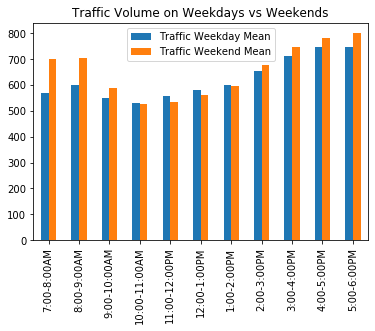

In [22]:
#combinded data frame of traffic on weekends and weekdays
#dow means days of the week
frames = [t_wdy_mean, t_wkd_mean]
t_dow_mean = pd.concat(frames)
t_dow_mean.T.plot.bar()
plt.title('Traffic Volume on Weekdays vs Weekends')
plt.show()

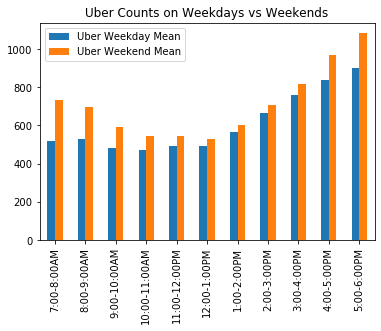

In [23]:
#combinded data frame of uber counts on weekends and weekdays
#dow means days of the week
frames = [u_wdy_mean, u_wkd_mean]
u_dow_mean = pd.concat(frames)
u_dow_mean.T.plot.bar()
plt.title('Uber Counts on Weekdays vs Weekends')
plt.show()

In [45]:
print ("Traffic standard deviation for weekday:\n",traffic_day_of_week.iloc[:5, :].std())

print("\nTraffic standard deviation for weekend:\n",traffic_day_of_week.iloc[5:7, :].std())

Traffic standard deviation for weekday:
 7:00-8:00AM      260.365674
8:00-9:00AM      215.672072
9:00-10:00AM      99.070338
10:00-11:00AM     21.099212
11:00-12:00PM     40.714712
12:00-1:00PM      49.759122
1:00-2:00PM       42.656052
2:00-3:00PM       20.393076
3:00-4:00PM       30.527833
4:00-5:00PM       43.983340
5:00-6:00PM       55.243976
dtype: float64

Traffic standard deviation for weekend:
 7:00-8:00AM       5.021663
8:00-9:00AM       4.543792
9:00-10:00AM      7.498852
10:00-11:00AM    11.759559
11:00-12:00PM    29.333409
12:00-1:00PM     37.169081
1:00-2:00PM      45.380019
2:00-3:00PM      48.358356
3:00-4:00PM      52.728267
4:00-5:00PM      29.243081
5:00-6:00PM      20.485368
dtype: float64


In [46]:
print ("Uber standard deviation for weekday:\n",uber_day_of_week.iloc[:5, :].std())

print("\nUber standard deviation for weekend:\n",uber_day_of_week.iloc[5:7, :].std())

Uber standard deviation for weekday:
 7:00-8:00AM      248.581375
8:00-9:00AM      190.863302
9:00-10:00AM      79.199116
10:00-11:00AM     49.643731
11:00-12:00PM     52.952809
12:00-1:00PM      75.681570
1:00-2:00PM       81.287760
2:00-3:00PM      114.204641
3:00-4:00PM      123.516396
4:00-5:00PM      129.442265
5:00-6:00PM      159.488244
dtype: float64

Uber standard deviation for weekend:
 7:00-8:00AM      175.362482
8:00-9:00AM      162.634560
9:00-10:00AM     115.965512
10:00-11:00AM     79.903066
11:00-12:00PM     80.610173
12:00-1:00PM      52.325902
1:00-2:00PM       36.062446
2:00-3:00PM       22.627417
3:00-4:00PM       12.020815
4:00-5:00PM       51.618795
5:00-6:00PM       24.748737
dtype: float64
